# Naive approach random_forest + optuna - holidays

In [1]:
model_name = 'random_forest_with_holidays_seasonality_features'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


### Features

In [22]:
import holidays

def transform_date(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)
    
    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    # weekend
    #df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    # drop date
    #df = df.drop('date', axis=1)

    # one-hot encoding of 'country', 'store', 'product' columns
    #df_train = pd.get_dummies(df_train, columns=['country', 'store', 'product'])


    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    return df

def encode_cat_variables(df):
    categorical_features = ["country", "store", "product"]
    df = pd.get_dummies(df, columns=categorical_features)
    return df

def add_holidays(df):
    # courtesy of kacperrabczewski in https://www.kaggle.com/code/kacperrabczewski/last-minute-forecasting#Modeling-%F0%9F%AA%84

    years_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

    Argentina_holidays = holidays.CountryHoliday('AR', years=years_list)
    Canada_holidays = holidays.CountryHoliday('CA', years=years_list)
    Estonia_holidays = holidays.CountryHoliday('EE', years=years_list)
    Japan_holidays = holidays.CountryHoliday('JP', years=years_list)
    Spain_holidays = holidays.CountryHoliday('ES', years=years_list)
    
    # Create Holiday Column 
    df['Argentina_holiday'] = df.loc[df['country'] == 'Argentina', 'date'].apply(lambda d: True if d in Argentina_holidays else False)
    df['Canada_holiday'] = df.loc[df['country'] == 'Canada', 'date'].apply(lambda d: True if d in Canada_holidays else False)
    df['Estonia_holiday'] = df.loc[df['country'] == 'Estonia', 'date'].apply(lambda d: True if d in Estonia_holidays else False)
    df['Japan_holiday'] = df.loc[df['country'] == 'Japan', 'date'].apply(lambda d: True if d in Japan_holidays else False)
    df['Spain_holiday'] = df.loc[df['country'] == 'Spain', 'date'].apply(lambda d: True if d in Spain_holidays else False)

    df['Argentina_holiday'] = df['Argentina_holiday'].fillna(False)
    df['Canada_holiday'] = df['Canada_holiday'].fillna(False)
    df['Estonia_holiday'] = df['Estonia_holiday'].fillna(False)
    df['Japan_holiday'] = df['Japan_holiday'].fillna(False)
    df['Spain_holiday'] = df['Spain_holiday'].fillna(False)

    df = df.drop('date', axis=1)

    return df

def seasonality_features(df):
    
    # getting seasonal patterns
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df['day_sin'] = np.sin(2*np.pi*df.dayofmonth/31)
    df['day_cos'] = np.cos(2*np.pi*df.dayofmonth/31)
    return df

df_train_0 = transform_date(df_train)
df_train_0 = create_features(df_train_0)
df_train_0 = add_holidays(df_train_0)
df_train_0 = seasonality_features(df_train_0)
df_train_0 = encode_cat_variables(df_train_0)
df_train_0.head()

,id,num_sold,year,month,day,week_number,dayofweek,dayofmonth,Argentina_holiday,Canada_holiday,...,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,0,63,2017,1,1,52,6,1,True,False,...,False,False,False,True,False,True,False,False,False,False
1,1,66,2017,1,1,52,6,1,True,False,...,False,False,False,True,False,False,True,False,False,False
2,2,9,2017,1,1,52,6,1,True,False,...,False,False,False,True,False,False,False,True,False,False
3,3,59,2017,1,1,52,6,1,True,False,...,False,False,False,True,False,False,False,False,True,False
4,4,49,2017,1,1,52,6,1,True,False,...,False,False,False,True,False,False,False,False,False,True


In [4]:
model_features = df_train_0.columns.tolist()
model_features.remove("num_sold")
model_features

['year',
 'month',
 'day',
 'week_number',
 'dayofweek',
 'dayofmonth',
 'Argentina_holiday',
 'Canada_holiday',
 'Estonia_holiday',
 'Japan_holiday',
 'Spain_holiday',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'country_Argentina',
 'country_Canada',
 'country_Estonia',
 'country_Japan',
 'country_Spain',
 'store_Kagglazon',
 'store_Kaggle Learn',
 'store_Kaggle Store',
 'product_Using LLMs to Improve Your Coding',
 'product_Using LLMs to Train More LLMs',
 'product_Using LLMs to Win Friends and Influence People',
 'product_Using LLMs to Win More Kaggle Competitions',
 'product_Using LLMs to Write Better']

In [5]:
df_train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 29 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   num_sold                                                136950 non-null  int64  
 1   year                                                    136950 non-null  int32  
 2   month                                                   136950 non-null  int32  
 3   day                                                     136950 non-null  int32  
 4   week_number                                             136950 non-null  int32  
 5   dayofweek                                               136950 non-null  int32  
 6   dayofmonth                                              136950 non-null  int32  
 7   Argentina_holiday                                       136950 non-null  bool   
 8   Canada_holiday          

Function by which submissions are scored is SMAPE:

In [6]:
def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import optuna

train_index, val_index = [ x for x in TimeSeriesSplit(n_splits=5).split(df_train_0) ][-1]

X_train = df_train_0.iloc[train_index][model_features]
y_train = df_train_0.iloc[train_index]['num_sold']

X_val = df_train_0.iloc[val_index][model_features]
y_val = df_train_0.iloc[val_index]['num_sold']

cat_features_indices = np.where((X_train.dtypes == "category") | (X_train.dtypes == "object"))[0]
cat_features_indices

def objective(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
        max_depth=trial.suggest_int('max_depth', 10, 110),
        bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
        min_samples_leaf=trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
        min_samples_split=trial.suggest_categorical('min_samples_split', [2, 5, 10]),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(
        X_train, y_train,
    )

    return SMAPE(y_val, np.round(model.predict(X_val)))


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)

best_hyperparams = study.best_params

[I 2023-07-29 17:46:43,834] A new study created in memory with name: no-name-c841a05f-91d1-4772-8e0e-9675ddc600a4
[I 2023-07-29 17:46:47,377] Trial 0 finished with value: 11.566759194221476 and parameters: {'n_estimators': 219, 'max_depth': 42, 'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 10, 'max_features': 'log2'}. Best is trial 0 with value: 11.566759194221476.
[I 2023-07-29 17:46:57,084] Trial 1 finished with value: 12.986124557526388 and parameters: {'n_estimators': 420, 'max_depth': 36, 'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 11.566759194221476.
[I 2023-07-29 17:47:00,287] Trial 2 finished with value: 12.911096115200902 and parameters: {'n_estimators': 147, 'max_depth': 96, 'bootstrap': False, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 11.566759194221476.
[I 2023-07-29 17:47:24,702] Trial 3 finished with value: 14.001412783682

In [8]:
best_hyperparams

{'n_estimators': 551,
 'max_depth': 89,
 'bootstrap': True,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'max_features': 'log2'}

In [9]:
# split into train and validation

results_smape = []
results_r2 = []
results_mse = []


N_SPLITS = 5

for train_index, val_index in TimeSeriesSplit(n_splits=N_SPLITS).split(df_train_0):
    X_train = df_train_0.iloc[train_index][model_features]
    y_train = df_train_0.iloc[train_index]['num_sold']

    X_val = df_train_0.iloc[val_index]
    y_val = df_train_0.iloc[val_index]['num_sold']

    model = RandomForestRegressor(**best_hyperparams)
    model.fit(X_train, y_train)

    # evaluate on validation set
    y_pred = np.round(model.predict(X_val[model_features]))

    smape = SMAPE(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    results_smape.append(smape)
    results_r2.append(r2)
    results_mse.append(mse)
    del model

print("Cross validated results:")

print("SMAPE: %s" % results_smape)
print("R2: %s" % results_r2)
print("MSE: %s" % results_mse)

print("Mean results:")
print("SMAPE: %.4f" % np.mean(results_smape))
print("R2: %.4f" % np.mean(results_r2))
print("MSE: %.4f" % np.mean(results_mse))


# add a row with results to csv file leaderboard.csv

row = [model_name, np.mean(results_smape), np.mean(results_r2), np.mean(results_mse)]
with open('leaderboard.csv', 'a') as fd:
    import csv
    fd.write('\n')
    writer = csv.writer(fd, delimiter=',', lineterminator=';\n')
    writer.writerow(row)

Cross validated results:
SMAPE: [13.679397518854675, 12.259456791437142, 15.82109365876616, 12.069286983286412, 10.806038405606309]
R2: [0.9591191915372383, 0.9817052668820173, 0.966976158745986, 0.9761584287199884, 0.9543250592480486]
MSE: [1441.3864184008762, 638.9366484118291, 1038.9522453450165, 752.961139101862, 1789.9235487404162]
Mean results:
SMAPE: 12.9271
R2: 0.9677
MSE: 1132.4320


In [11]:
# train and predict for submission

df_train = pd.read_csv(data_path + "train.csv")
df_train['date'] = pd.to_datetime(df_train['date'])

df_train_0 = transform_date(df_train)
df_train_0 = create_features(df_train_0)
df_train_0 = add_holidays(df_train_0)
df_train_0 = seasonality_features(df_train_0)
df_train_0 = encode_cat_variables(df_train_0)

X_train = df_train_0.drop('num_sold', axis=1)
y_train = df_train_0['num_sold']


model = RandomForestRegressor(**best_hyperparams)
model.fit(X_train[model_features], y_train)

df_val = X_val.copy()
df_val['actual'] = y_val
df_val['prediction'] = model.predict(df_val[model_features])
df_val['prediction'] = df_val['prediction'].astype(int)

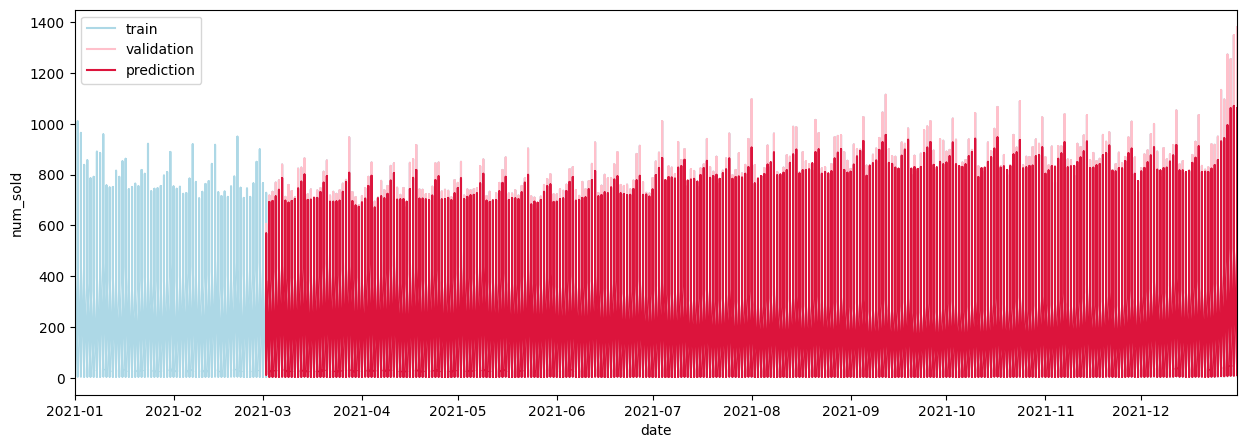

In [12]:
import datetime

X_train['date'] = pd.to_datetime(X_train['year'].astype(str) + '-' + X_train['month'].astype(str) + '-' + X_train['day'].astype(str))
X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))
df_val['date'] = pd.to_datetime(df_val['year'].astype(str) + '-' + df_val['month'].astype(str) + '-' + df_val['day'].astype(str))

# sort by date
X_train.sort_values(by='date', inplace=True)
X_val.sort_values(by='date', inplace=True)

# plot 'num_sold' vs 'date'
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(X_train['date'], y_train, label='train', color='lightblue')
ax.plot(X_val['date'], y_val, label='validation', color='pink')
ax.plot(df_val['date'], df_val['prediction'], label='prediction', color='crimson')

# x axis show only from 2021 onwards
ax.set_xlim([datetime.date(2021, 1, 1), df_val['date'].max()])
ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax.legend()
plt.show()

In [14]:
model_features

['year',
 'month',
 'day',
 'week_number',
 'dayofweek',
 'dayofmonth',
 'Argentina_holiday',
 'Canada_holiday',
 'Estonia_holiday',
 'Japan_holiday',
 'Spain_holiday',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'country_Argentina',
 'country_Canada',
 'country_Estonia',
 'country_Japan',
 'country_Spain',
 'store_Kagglazon',
 'store_Kaggle Learn',
 'store_Kaggle Store',
 'product_Using LLMs to Improve Your Coding',
 'product_Using LLMs to Train More LLMs',
 'product_Using LLMs to Win Friends and Influence People',
 'product_Using LLMs to Win More Kaggle Competitions',
 'product_Using LLMs to Write Better']

In [17]:
df_test_0.columns

Index(['id', 'year', 'month', 'day', 'week_number', 'dayofweek', 'dayofmonth',
       'Argentina_holiday', 'Canada_holiday', 'Estonia_holiday',
       'Japan_holiday', 'Spain_holiday', 'country_Argentina', 'country_Canada',
       'country_Estonia', 'country_Japan', 'country_Spain', 'store_Kagglazon',
       'store_Kaggle Learn', 'store_Kaggle Store',
       'product_Using LLMs to Improve Your Coding',
       'product_Using LLMs to Train More LLMs',
       'product_Using LLMs to Win Friends and Influence People',
       'product_Using LLMs to Win More Kaggle Competitions',
       'product_Using LLMs to Write Better'],
      dtype='object')

In [23]:
# test 

df_test = pd.read_csv(data_path + "test.csv")
df_test_0 = transform_date(df_test)
df_test_0 = create_features(df_test_0)
df_test_0 = add_holidays(df_test_0)
df_test_0 = seasonality_features(df_test_0)
df_test_0 = encode_cat_variables(df_test_0)

# predict for test set
df_test['prediction'] = model.predict(df_test_0[model_features])
df_test['prediction'] = df_test['prediction'].astype(int)
df_test

,id,date,country,store,product,year,month,day,week_number,dayofweek,dayofmonth,Argentina_holiday,Canada_holiday,Estonia_holiday,Japan_holiday,Spain_holiday,prediction
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,52,5,1,True,False,False,False,False,42
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,52,5,1,True,False,False,False,False,40
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,52,5,1,True,False,False,False,False,9
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,52,5,1,True,False,False,False,False,40
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,52,5,1,True,False,False,False,False,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,52,5,31,False,False,False,False,False,642
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,52,5,31,False,False,False,False,False,651
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,52,5,31,False,False,False,False,False,135
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,52,5,31,False,False,False,False,False,601


In [24]:
df_test['num_sold'] = df_test['prediction']
df_test[['id', 'num_sold']].to_csv(f'{model_name}_submission.csv', index=False)